# 1. Setup & Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.utils as U
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torchvision.transforms import GaussianBlur, RandomSolarize
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import hdbscan
from collections import defaultdict, Counter       
import pickle
from pathlib import Path
from typing import List, Tuple
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparameters
BATCH_SIZE = 512
LR = 1e-3
EPOCHS_SIMCLR = 50     # Warmup 50
# Using rounded to balance between hard rounds and random rounds
TOTAL_TRIPLET_EPOCHS = 50 # 50
MARGIN = 0.15           # Distance between nodes needed to be clustered
RANDOM_EPOCHS_PER_CYCLE = 15
HARD_EPOCHS_PER_CYCLE = 0


c:\git\SemiSupClassifyNet\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


# 2. Data Loading & Transformations (CIFAR-100)


In [2]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# train_dataset_raw = datasets.CIFAR100(
#     root="./data",
#     train=True,
#     download=True,
#     transform=train_transform
# )
test_dataset_raw = datasets.CIFAR100(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)

simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    # ─── stronger view augmentations (like MoCo v2 / BYOL) ───
    transforms.RandomApply([GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))], p=0.5),
    transforms.RandomApply([RandomSolarize(threshold=128)],               p=0.2),
    # ----------------------------------------------------------
    transforms.ToTensor()
])


In [3]:
#Read in CIFAR 100: print the super classes and fine classes
 
#Load CIFAR-100 metadata
def load_cifar100_metadata(meta_path='./data/cifar-100-python/meta'):
    with open(meta_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    return data['fine_label_names'], data['coarse_label_names'], data

fine_label_names, coarse_label_names, meta_raw = load_cifar100_metadata()

#Print each superclass and its fine classes on the same line
print("CIFAR-100 Superclasses and Their Fine Classes:\n")

#Each fine label has a fixed superclass index (length 100 list)
coarse_label_of_fine = meta_raw['coarse_label_names']
superclass_to_fine_names = {name: [] for name in coarse_label_names}

#Manually build the map using the known order of classes (fine 0-99)
with open('./data/cifar-100-python/train', 'rb') as f:
    train_data = pickle.load(f, encoding='latin1')

for coarse, fine in zip(train_data['coarse_labels'], train_data['fine_labels']):
    superclass_name = coarse_label_names[coarse]
    subclass_name = fine_label_names[fine]
    if subclass_name not in superclass_to_fine_names[superclass_name]:
        superclass_to_fine_names[superclass_name].append(subclass_name)

#Pretty print
for superclass, subclasses in superclass_to_fine_names.items():
    print(f"{superclass}: {', '.join(subclasses)}")

CIFAR-100 Superclasses and Their Fine Classes:

aquatic_mammals: otter, seal, whale, beaver, dolphin
fish: aquarium_fish, shark, flatfish, ray, trout
flowers: sunflower, rose, tulip, poppy, orchid
food_containers: cup, bottle, plate, bowl, can
fruit_and_vegetables: apple, mushroom, sweet_pepper, orange, pear
household_electrical_devices: telephone, keyboard, television, clock, lamp
household_furniture: table, chair, wardrobe, couch, bed
insects: cockroach, butterfly, bee, caterpillar, beetle
large_carnivores: wolf, leopard, lion, tiger, bear
large_man-made_outdoor_things: castle, skyscraper, road, bridge, house
large_natural_outdoor_scenes: cloud, sea, mountain, forest, plain
large_omnivores_and_herbivores: cattle, elephant, chimpanzee, camel, kangaroo
medium_mammals: possum, skunk, raccoon, fox, porcupine
non-insect_invertebrates: lobster, snail, worm, crab, spider
people: boy, woman, girl, man, baby
reptiles: dinosaur, snake, crocodile, turtle, lizard
small_mammals: squirrel, shrew, 

In [4]:
# === Cell A — run ONCE to create & save a brand-new split ================

import json, random, pickle
from pathlib import Path
from torchvision import datasets
from torch.utils.data import Subset


# helper: map coarse-ID to {fine-IDs} and fine-ID to coarse-ID

def build_mappings(train_pickle="./data/cifar-100-python/train"):
    with open(train_pickle, "rb") as f:
        d = pickle.load(f, encoding="latin1")
    coarse_to_fine, fine_to_coarse = {}, {}
    for c, f in zip(d["coarse_labels"], d["fine_labels"]):
        coarse_to_fine.setdefault(c, set()).add(f)
        fine_to_coarse[f] = c
    return coarse_to_fine, fine_to_coarse

coarse_to_fine, fine_to_coarse = build_mappings()

# 1.  pick 10 super-classes  +  1+4 fine-classes each
rng = random.Random(42)    
selected_coarse_ids = rng.sample(list(coarse_to_fine), k=10)

selected_fine_ids = []          # 10   – goes into the TRAIN set
extra_fine_ids    = []          # 40   – goes into the STREAM set
for c in selected_coarse_ids:
    fine_pool = list(coarse_to_fine[c])
    rng.shuffle(fine_pool)
    selected_fine_ids.append(fine_pool[0])   
    extra_fine_ids.extend(fine_pool[1:5]) 


# 2.  SAVE the choice so future runs can reproduce it
Path("class_selection.json").write_text(
    json.dumps({"selected_fine": selected_fine_ids,
                "extra_fine":    extra_fine_ids}, indent=2))
print("✔ new split saved to class_selection.json")


train_dataset_raw = datasets.CIFAR100(root="./data",
                                      train=True,
                                      download=True,
                                      transform=train_transform)

train_indices  = [i for i, y in enumerate(train_dataset_raw.targets)
                  if y in selected_fine_ids]
stream_indices = [i for i, y in enumerate(train_dataset_raw.targets)
                  if y in extra_fine_ids]

train_dataset_filtered  = Subset(train_dataset_raw, train_indices)
stream_dataset_filtered = Subset(train_dataset_raw, stream_indices)

print(f"super-classes: {selected_coarse_ids}")
print(f"train classes : {selected_fine_ids}")
print(f"stream classes: {extra_fine_ids}")
print(f"train images  : {len(train_indices)}")
print(f"stream images : {len(stream_indices)}")


✔ new split saved to class_selection.json
super-classes: [14, 11, 10, 3, 19, 4, 9, 15, 2, 7]
train classes : [35, 21, 33, 9, 89, 83, 17, 93, 82, 24]
stream classes: [98, 46, 11, 2, 19, 31, 15, 38, 23, 49, 71, 60, 61, 16, 28, 10, 85, 81, 41, 69, 53, 0, 57, 51, 37, 12, 68, 76, 27, 78, 29, 44, 62, 54, 92, 70, 7, 14, 6, 18]
train images  : 5000
stream images : 20000


# 3. Supervised Warm-Up (SIMple Contrastive LeaRning SimCLR-like)


In [6]:
class SimCLRDataset(Dataset):
    #Takes the same image and mutates it in some way
    #While telling the network they're the same
    #Pulls out general features
    def __init__(self, base_dataset, transform=None, second_transform=None):
        super().__init__()
        self.base_dataset = base_dataset
        self.transform = transform
        self.second_transform = second_transform if second_transform else transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        raw_img = self.base_dataset.data[idx]
        pil_img = Image.fromarray(raw_img)
        img1 = self.transform(pil_img)
        img2 = self.second_transform(pil_img)
        return img1, img2
    
class LabeledSimCLRDataset(Dataset):
    def __init__(self, base_dataset, transform):
        self.ds = base_dataset
        self.t  = transform

    def __len__(self): return len(self.ds)

    def __getitem__(self, idx):
        img, y = self.ds[idx]                  
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)
        img1 = self.t(img)
        img2 = self.t(img)
        return img1, img2, y                   


# class SimpleConvBase(nn.Module):
#     #Extreamly basic CNN, probably need to make it more complex for better results
#     def __init__(self, out_dim=256):
#         super(SimpleConvBase, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 32, 3, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2),  #16x16

#             nn.Conv2d(32, 64, 3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2),  #8x8

#             nn.Conv2d(64, 128, 3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.AdaptiveAvgPool2d((1,1))
#         )
#         self.fc = nn.Linear(128, out_dim)

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

class Res18Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        base = resnet18(weights=None)            
        self.backbone = nn.Sequential(*list(base.children())[:-2])
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.out_dim = 512                   

    def forward(self, x):
        h = self.gap(self.backbone(x)).flatten(1)  # [B,512]
        return h
    
    
def sanity_monitor(model, loader_seed, epoch, device="cuda"):
    """Call at the *end* of every SimCLR epoch."""
    #1) gradient norm (computed during the *previous* backward pass)
    grad_l2 = 0.0
    n = 0
    for p in model.encoder.parameters():
        if p.grad is not None:
            grad_l2 += (p.grad.detach().norm(2).item() ** 2)
            n += 1
    grad_l2 = (grad_l2 / max(n, 1)) ** 0.5

    #2)projection variance
    with torch.no_grad():
        zs = []
        ys = []
        for xb, _, yb in loader_seed:          
            xb = xb.to(device)
            _, z = model(xb)                   # projection head output
            zs.append(F.normalize(z, dim=1).cpu())
            ys.append(yb)
        Z = torch.cat(zs)
        proj_var = torch.var(Z, dim=0).mean().item()

    #3)linear probe on SEED split (very small & quick)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(Z.numpy(), torch.cat(ys).numpy())
    probe_acc = clf.score(Z.numpy(), torch.cat(ys).numpy())

    print(f"[E{epoch:03}] grad ℓ2={grad_l2:.4f} | proj var={proj_var:.3f} | lin-probe={probe_acc:.3f}")


class SimCLRModel(nn.Module):
    def __init__(self, encoder=None, proj_dim=64):
        super().__init__()
        self.encoder = encoder or Res18Encoder()
        feat_dim    = self.encoder.out_dim
        self.projection = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.ReLU(inplace=True),
            nn.Linear(feat_dim, proj_dim)
        )

    def forward(self, x):
        h = self.encoder(x)        # [B,512]
        z = self.projection(h)     # [B,64]
        return h, z


def nt_xent_loss(z_i, z_j, temperature=0.08):
    """
    z_i , z_j : [B,D]   two augmented views
    returns scalar loss
    """
    B = z_i.size(0)
    z   = F.normalize(torch.cat([z_i, z_j], dim=0), dim=1)   # [2B,D]
    sim = (z @ z.T) / temperature                            # [2B,2B]


    diag_mask = torch.eye(2*B, device=z.device, dtype=torch.bool)
    sim_no_diag = sim.masked_fill(diag_mask, -1e9)       


    pos_idx = torch.arange(B, device=z.device)
    # positives = torch.cat([sim_no_diag[pos_idx, pos_idx+B],
    #                        sim_no_diag[pos_idx+B, pos_idx]])


    log_prob = sim_no_diag - torch.logsumexp(sim_no_diag, dim=1, keepdim=True)
    loss = -log_prob[pos_idx, pos_idx+B].mean() - log_prob[pos_idx+B, pos_idx].mean()
    return loss


class SupConLoss(nn.Module):
    def __init__(self, temperature=0.08):
        super().__init__()
        self.t = temperature

    def forward(self, features, labels):
        device, n_views = features.device, 2
        B = labels.size(0)

        #build mask of positives
        labels   = labels.view(-1, 1)                     # [B,1]
        mask_pos = torch.eq(labels, labels.T).float().to(device)   # [B,B]

        # create 2B×2B feature matrix
        feat = features.view(n_views, B, -1)              # [2,B,D]
        feat = torch.cat(torch.unbind(feat, dim=0), dim=0)   # [2B,D]

        # cosine-sim / τ
        logits = torch.div(feat @ feat.T, self.t)         # [2B,2B]

        # numerical stability 
        logits = logits - logits.max(dim=1, keepdim=True).values.detach()

        #build *binary* mask to filter self-contrast 
        eye   = torch.eye(2 * B, device=device)
        mask  = mask_pos.repeat(n_views, n_views)         # [2B,2B]
        mask  = mask * (1. - eye)                         # zero diagonal

        #log-prob of positive pairs
        exp_logits = torch.exp(logits) * (1. - eye)       # keep graph intact
        log_prob   = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-12)

        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-12)

        loss = -mean_log_prob_pos.mean()
        return loss


SimCLR Warm-Up Training with 50 Epochs
[Warm-up E1] avg loss = 14.4090
[E001] grad ℓ2=5.9650 | proj var=0.010 | lin-probe=0.364
[Warm-up E2] avg loss = 12.2259
[E002] grad ℓ2=5.2320 | proj var=0.012 | lin-probe=0.391
[Warm-up E3] avg loss = 9.8213
[E003] grad ℓ2=4.7377 | proj var=0.014 | lin-probe=0.421
[Warm-up E4] avg loss = 7.7520
[E004] grad ℓ2=4.2279 | proj var=0.015 | lin-probe=0.452
[Warm-up E5] avg loss = 6.5340
[E005] grad ℓ2=3.6184 | proj var=0.015 | lin-probe=0.454
[Warm-up E6] avg loss = 5.7489
[E006] grad ℓ2=2.8246 | proj var=0.015 | lin-probe=0.471
[Warm-up E7] avg loss = 5.1819
[E007] grad ℓ2=2.8949 | proj var=0.016 | lin-probe=0.461
[Warm-up E8] avg loss = 4.8047
[E008] grad ℓ2=2.4663 | proj var=0.016 | lin-probe=0.477
[Warm-up E9] avg loss = 4.4561
[E009] grad ℓ2=2.4145 | proj var=0.016 | lin-probe=0.484
[Warm-up E10] avg loss = 4.1807
[E010] grad ℓ2=2.2437 | proj var=0.016 | lin-probe=0.480
[Warm-up E11] avg loss = 3.9887
[E011] grad ℓ2=1.9525 | proj var=0.016 | lin-p

Text(0.5, 1.0, 'SimCLR features before triplet training')

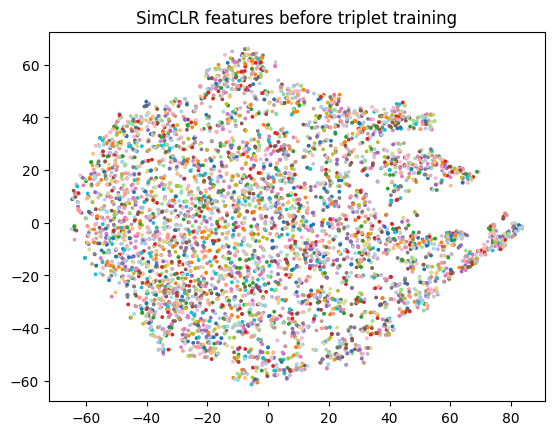

In [7]:
def train_simclr_epoch(model, loader, optimizer, epoch, temperature=0.08):
    model.train()
    total_loss = 0
    for img1, img2 in loader:
        img1 = img1.to(device)
        img2 = img2.to(device)

        optimizer.zero_grad()
        _, z1 = model(img1)
        _, z2 = model(img2)

        loss = nt_xent_loss(z1, z2, temperature=temperature)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"[SimCLR E{epoch}] Loss={avg_loss:.4f}")
    return avg_loss

def train_simclr_epoch(model, loaders,   
                       optimizer, epoch,
                       supcon_loss, nt_xent_temperature=0.08):

    model.train()
    total_loss, n_batches = 0.0, 0

    # iterate over *both* loaders
    for which, loader in zip(("sup", "unsup"), loaders):
        for batch in loader:
            if which == "sup":
                img1, img2, labels = batch
            else:
                img1, img2 = batch
                labels = None

            img1, img2 = img1.to(device), img2.to(device)
            if labels is not None:
                labels = labels.to(device)

            optimizer.zero_grad()
            _, z1 = model(img1)
            _, z2 = model(img2)

            if labels is None:                          # ordinary SimCLR
                loss = nt_xent_loss(z1, z2,
                                    temperature=nt_xent_temperature)
            else:                                       # Supervised-contrastive
                z = torch.cat([z1, z2], dim=0)          # [2B, D]
                loss = supcon_loss(z, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            n_batches  += 1

    print(f"[Warm-up E{epoch}] avg loss = {total_loss / n_batches:.4f}")


simclr_dataset = SimCLRDataset(
    base_dataset=train_dataset_raw,
    transform=simclr_transform,
    second_transform=simclr_transform
)

labeled_loader = DataLoader(
    LabeledSimCLRDataset(train_dataset_filtered, simclr_transform),
    batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=0)

simclr_loader = DataLoader(
    simclr_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=0
)

simclr_model = SimCLRModel().to(device)
supcon_loss_fn = SupConLoss(temperature=0.08)
optimizer_simclr = optim.Adam(simclr_model.parameters(), lr=1e-4)

print(f"SimCLR Warm-Up Training with {EPOCHS_SIMCLR} Epochs")
#torch.autograd.set_detect_anomaly(True) ## Debugging only
for e in range(1, EPOCHS_SIMCLR + 1):
    train_simclr_epoch(simclr_model,
                       loaders=(labeled_loader, simclr_loader),
                       optimizer=optimizer_simclr,
                       epoch=e,
                       supcon_loss=supcon_loss_fn)
    sanity_monitor(simclr_model, labeled_loader, e, device=device)
    
#Check the features before triplet training
with torch.no_grad():
    feats = []
    for xb,_ in DataLoader(train_dataset_filtered, batch_size=512):
        feats.append(simclr_model.encoder(xb.to(device)).cpu())
Z = torch.cat(feats)
tsne = TSNE(2, perplexity=30).fit_transform(Z)
plt.scatter(tsne[:,0], tsne[:,1], s=3, c=train_dataset_filtered.dataset.targets[:len(Z)], cmap='tab20')
plt.title('SimCLR features before triplet training')


# 4. Triplet Network Training & Distance Checks

In [8]:
class TripletNet(nn.Module):
    #Augmenting the existing CNN to use the triplet system
    def __init__(self, encoder):
        super(TripletNet, self).__init__()
        self.encoder = encoder

        #learnable scale factor for embeddings
        self.scale = nn.Parameter(torch.tensor(3.0))

    def forward(self, anchor, positive, negative):
        a = self.get_embedding(anchor)
        p = self.get_embedding(positive)
        n = self.get_embedding(negative)
        return a, p, n

    def get_embedding(self, x):
        #Get raw CNN output
        raw_emb = self.encoder(x)
        #Normalize to unit sphere then stretch by scale factor
        emb = F.normalize(raw_emb, p=2, dim=1) * self.scale
        return emb


def build_embedding_cache(model, dataset):
    #Store image embeddings rather than constantly recalculating
    loader = DataLoader(dataset, batch_size=2048, shuffle=False, pin_memory=True, num_workers=0)
    cache_list = []
    model.eval()
    with torch.no_grad():
        for (imgs, _) in loader:
            imgs = imgs.to(device)
            emb_batch = model.get_embedding(imgs).cpu().numpy()
            cache_list.append(emb_batch)
    return np.concatenate(cache_list, axis=0)


class OnlineTripletDataset(Dataset):
    """
    Works for either
        • a raw dataset that owns `.targets`
        • or a torch.utils.data.Subset wrapped around one.
    Returns (img, label) so the batch-hard loss can mine its own triplets.
    """
    def __init__(self, base_dataset):
        super().__init__()
        self.base_dataset = base_dataset            


        if hasattr(base_dataset, "targets"):                
            self.labels = base_dataset.targets                 
        elif isinstance(base_dataset, Subset):
            inner = base_dataset.dataset                        # unwrap
            self.labels = [inner.targets[i] for i in base_dataset.indices]

            self.subset_indices = base_dataset.indices
        else:
            raise TypeError(f"Unsupported dataset type: {type(base_dataset)}")


        self.lbl_to_idx = defaultdict(list)
        for idx, y in enumerate(self.labels):
            self.lbl_to_idx[y].append(idx)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # when base_dataset is a Subset we must redirect to its original index
        if hasattr(self, "subset_indices"):
            true_idx = self.subset_indices[idx]
            img, _   = self.base_dataset.dataset[true_idx]
        else:
            img, _   = self.base_dataset[idx]
        return img, self.labels[idx]

In [9]:
def _k(cid: int | str) -> str:
    """Canonical string key for prototypes (e.g. c0, c1, …)."""
    if cid == "noise":                     # defensive guard
        raise ValueError("noise cluster should never need a prototype key")
    if isinstance(cid, str):
        if cid.startswith("c"):      
            return cid
        return "c" + cid              
    return f"c{cid}"           


class PrototypeLoss(nn.Module):
    def __init__(self, proto_dict, scale: float = 30.0, margin: float = 0.4, lambda_center: float = 5e-3):
        super().__init__()
        self.protos = proto_dict        
        self.s      = scale             
        self.m      = margin            
        self.lc     = lambda_center     

    def forward(self, emb: torch.Tensor, cluster_ids: torch.Tensor) -> torch.Tensor:

        # prototype centre-pull term
        keys   = [_k(c) for c in cluster_ids.tolist()]
        centers = torch.stack([self.protos[k] for k in keys], dim=0).to(emb)

        center_loss = (emb - F.normalize(centers, dim=1) * self.s) \
                          .pow(2).sum(1).mean()

        #ArcFace margin term 
        #Build matrix of all prototypes (row-normalised)
        all_centers = torch.stack([F.normalize(p, dim=0)
                                   for p in self.protos.values()]).to(emb)

        logits = (emb @ all_centers.t()) * self.s            # [B, C]

        true_idx = torch.tensor(
            [list(self.protos.keys()).index(k) for k in keys],
            device=emb.device
        )                                                    # [B]

        theta    = logits.gather(1, true_idx.unsqueeze(1)) / self.s
        logits_m = logits.clone()                           
        logits_m.scatter_(1, true_idx.unsqueeze(1),
                          self.s * torch.cos(theta + self.m))

        arc_loss = F.cross_entropy(logits_m, true_idx)

        return arc_loss + self.lc * center_loss


In [10]:
def batch_hard_triplet_loss(emb, y, margin=0.2):

    # cosine distance = 1 – similarity
    d   = 1 - emb @ emb.t()                      # [B,B]
    mask_pos = (y[:,None] == y[None]).bool()
    mask_neg = ~mask_pos

    hardest_pos = (d + (~mask_pos)*-1e9).max(1)[0]      # furthest positive
    hardest_neg = (d + (~mask_neg)*1e9 ).min(1)[0]      # closest negative
    loss = F.relu(hardest_pos - hardest_neg + margin).mean()
    return loss

def train_one_epoch_triplet(model, loader, optimizer, margin=MARGIN):

    model.train()
    running = 0
    for imgs, lbls in loader:
        imgs  = imgs.to(device)
        lbls  = lbls.to(device)

        optimizer.zero_grad()
        emb = F.normalize(model.get_embedding(imgs), dim=1)
        loss = batch_hard_triplet_loss(emb, lbls, margin)
        loss.backward()
        optimizer.step()
        running += loss.item()
    return running / len(loader)


def quick_distance_check(model, dataset, n_pairs=1000):
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[:2000]
    loader = DataLoader(Subset(dataset, indices), batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)

    emb_list = []
    lbl_list = []
    model.eval()
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            emb = model.get_embedding(imgs).cpu().numpy()
            emb_list.append(emb)
            lbl_list.append(labels.numpy())

    embeddings = np.concatenate(emb_list, axis=0)
    all_labels = np.concatenate(lbl_list, axis=0)
    n_data = embeddings.shape[0]

    same_dists = []
    diff_dists = []
    for _ in range(n_pairs):
        i1, i2 = np.random.randint(0, n_data, size=2)
        dist = np.linalg.norm(embeddings[i1] - embeddings[i2])
        if all_labels[i1] == all_labels[i2]:
            same_dists.append(dist)
        else:
            diff_dists.append(dist)

    if len(same_dists) > 0 and len(diff_dists) > 0:
        print(f"[DistCheck] same={np.mean(same_dists):.4f}, diff={np.mean(diff_dists):.4f}")
    else:
        print("Not enough pairs to measure.")


In [11]:
triplet_model = TripletNet(simclr_model.encoder).to(device)
optimizer_triplet = optim.Adam(triplet_model.parameters(), lr=LR)

print(f"Spliced Triplet Training with {TOTAL_TRIPLET_EPOCHS} Epochs")
current_epoch = 1
epochs_left = TOTAL_TRIPLET_EPOCHS

while epochs_left > 0:
    # Pure *online* batch-hard epochs (no random / hard split needed)
    for i in range(min(epochs_left, RANDOM_EPOCHS_PER_CYCLE)):
        random_dataset = OnlineTripletDataset(train_dataset_filtered)
        random_loader = DataLoader(
            random_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            pin_memory=False,
            num_workers=0
        )
        loss_r = train_one_epoch_triplet(triplet_model, random_loader, optimizer_triplet, margin=MARGIN)
        print(f"[Epoch {current_epoch}] RandomNeg Loss={loss_r:.4f}")
        quick_distance_check(triplet_model, train_dataset_filtered)

        current_epoch += 1
        epochs_left -= 1
        if epochs_left <= 0:
            break

    if epochs_left <= 0:
        break

online_dataset = OnlineTripletDataset(train_dataset_filtered)

online_loader  = DataLoader(
    online_dataset,
    batch_size=BATCH_SIZE,     
    shuffle=True,
    pin_memory=False,       
    num_workers=0
)

loss_bh = train_one_epoch_triplet(
    triplet_model,
    online_loader,
    optimizer_triplet,
    margin=MARGIN              
)

print(f"[Epoch {current_epoch}] BatchHard Loss = {loss_bh:.4f}")
quick_distance_check(triplet_model, train_dataset_filtered)

current_epoch += 1
epochs_left  -= 1

print("Finished Spliced Triplet Training")


Spliced Triplet Training with 50 Epochs
[Epoch 1] RandomNeg Loss=0.5443
[DistCheck] same=1.5244, diff=1.6667
[Epoch 2] RandomNeg Loss=0.4072
[DistCheck] same=2.0109, diff=2.1281
[Epoch 3] RandomNeg Loss=0.3696
[DistCheck] same=2.3882, diff=2.4969
[Epoch 4] RandomNeg Loss=0.3533
[DistCheck] same=2.5374, diff=2.6560
[Epoch 5] RandomNeg Loss=0.3380
[DistCheck] same=2.6428, diff=2.7376
[Epoch 6] RandomNeg Loss=0.3248
[DistCheck] same=2.6112, diff=2.7225
[Epoch 7] RandomNeg Loss=0.3150
[DistCheck] same=2.5442, diff=2.6555
[Epoch 8] RandomNeg Loss=0.3028
[DistCheck] same=2.5376, diff=2.6329
[Epoch 9] RandomNeg Loss=0.2936
[DistCheck] same=2.4712, diff=2.5714
[Epoch 10] RandomNeg Loss=0.2788
[DistCheck] same=2.3091, diff=2.4942
[Epoch 11] RandomNeg Loss=0.2664
[DistCheck] same=2.2855, diff=2.3785
[Epoch 12] RandomNeg Loss=0.2530
[DistCheck] same=2.1073, diff=2.2649
[Epoch 13] RandomNeg Loss=0.2366
[DistCheck] same=1.8155, diff=2.0378
[Epoch 14] RandomNeg Loss=0.2167
[DistCheck] same=1.6116, d

# **Save & Load Model Code Block**


In [ ]:
def save_triplet_model(model, optimizer, epoch, filepath="triplet_model_checkpoint.pth"):
    """
    model: TripletNet instance
    optimizer: optimizer_triplet
    epoch: current epoch or training step
    filepath: where to save
    """
    torch.save({
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict()
    }, filepath)
    print(f"Model saved to {filepath}")

def load_triplet_model(model, optimizer, filepath="triplet_model_checkpoint.pth"):
    """
    Load states into 'model' and 'optimizer'.
    """
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Model loaded from {filepath}, resume from epoch {start_epoch}")
    return start_epoch

In [12]:
# === Save the model ===
save_triplet_model(triplet_model, optimizer_triplet, current_epoch, "triplet_model_checkpoint.pth")


NameError: name 'save_triplet_model' is not defined

In [ ]:
# === Load the model ===
#resume_epoch = load_triplet_model(triplet_model, optimizer_triplet, "triplet_model_checkpoint.pth")


# 5. Data Visualization & Clustering

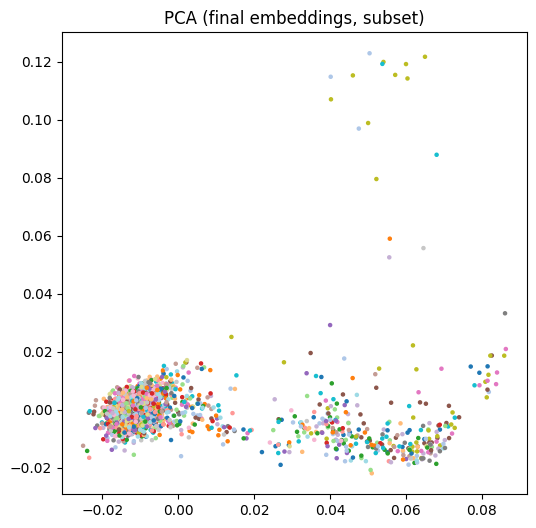

c:\git\SemiSupClassifyNet\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


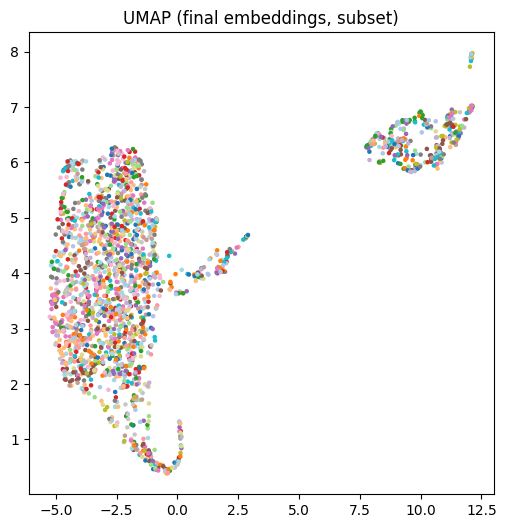

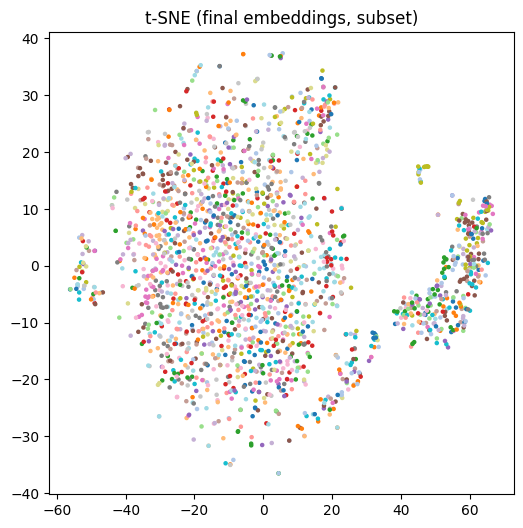

[HDBSCAN] Found 2 clusters (excluding noise label=-1).
 ARI=0.0026, NMI=0.0672


c:\git\SemiSupClassifyNet\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


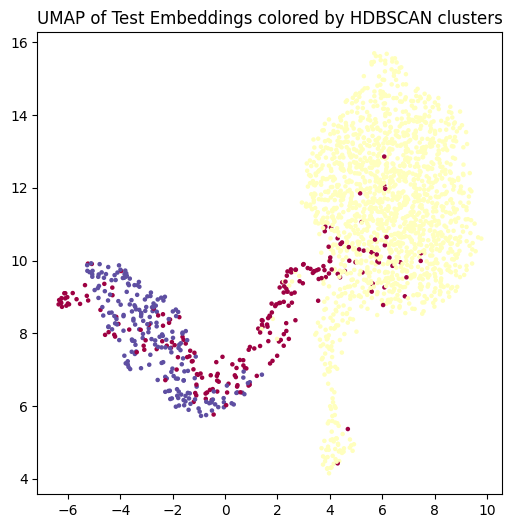

In [13]:
def embedding_visuals(model, dataset, max_images=2000):

    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[:max_images]

    sub_loader = DataLoader(
        Subset(dataset, indices),
        batch_size=BATCH_SIZE,
        shuffle=False,
        pin_memory=True,
        num_workers=0
    )

    emb_list = []
    lbl_list = []
    model.eval()
    with torch.no_grad():
        for imgs, labels in sub_loader:
            imgs = imgs.to(device)
            emb_batch = model.get_embedding(imgs).cpu().numpy()
            emb_list.append(emb_batch)
            lbl_list.append(labels.numpy())

    embeddings = np.concatenate(emb_list, axis=0)
    labels_np = np.concatenate(lbl_list, axis=0)

    #Principal Componenet Analysis
    #Finds directionality in data with the greatest variance
    #Simplified it "kinda" maps features to a directional vector and each feature pushes
    #a data point in a direction
    pca = PCA(n_components=2, random_state=42)
    emb_pca = pca.fit_transform(embeddings)
    plt.figure(figsize=(6,6))
    plt.scatter(emb_pca[:,0], emb_pca[:,1], c=labels_np, cmap='tab20', s=5)
    plt.title("PCA (final embeddings, subset)")
    plt.show()

    #Uniform Manifold Approximation and Projection
    #Maps data based on how likely or unlikely each point is to be close to
    #each other then maps this fuzzy distance understanding to 2d space
    reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.1, random_state=42)
    emb_umap = reducer.fit_transform(embeddings)
    plt.figure(figsize=(6,6))
    plt.scatter(emb_umap[:,0], emb_umap[:,1], c=labels_np, cmap='tab20', s=5)
    plt.title("UMAP (final embeddings, subset)")
    plt.show()

    #t-Distributed Stochastic Neighbor Embeddings
    #Creates "neighborhoods" to find groups of data that would be close to one another
    #Then uses this fuzzy understanding to group data together
    tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
    emb_tsne = tsne_model.fit_transform(embeddings)
    plt.figure(figsize=(6,6))
    plt.scatter(emb_tsne[:,0], emb_tsne[:,1], c=labels_np, cmap='tab20', s=5)
    plt.title("t-SNE (final embeddings, subset)")
    plt.show()


def cluster_test_set_hdbscan(model, dataset, max_images=2000):
    #Clusters dataset with HDBSCAN
    #Prints ARI and NMI for debuging purposes

    indices = list(range(len(dataset)))
    random.shuffle(indices)
    indices = indices[:max_images]

    loader = DataLoader(
        Subset(dataset, indices),
        batch_size=BATCH_SIZE,
        shuffle=False,
        pin_memory=True,
        num_workers=0
    )

    emb_list = []
    lbl_list = []
    model.eval()
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            emb = model.get_embedding(imgs).cpu().numpy()
            emb_list.append(emb)
            lbl_list.append(lbls.numpy())

    embeddings = np.concatenate(emb_list, axis=0)
    labels_np = np.concatenate(lbl_list, axis=0)

    mcs = int(np.sqrt(len(embeddings)))        # local fallback
    clusterer = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=10, cluster_selection_epsilon=0.05, metric="euclidean")
    preds = clusterer.fit_predict(embeddings)

    n_clusters = len(set(preds) - {-1})
    print(f"[HDBSCAN] Found {n_clusters} clusters (excluding noise label=-1).")

    valid_idx = preds != -1
    if np.sum(valid_idx) > 0:
        ari = adjusted_rand_score(labels_np[valid_idx], preds[valid_idx])
        nmi = normalized_mutual_info_score(labels_np[valid_idx], preds[valid_idx])
        print(f" ARI={ari:.4f}, NMI={nmi:.4f}")
    else:
        print(" No valid (non-noise) clusters for ARI/NMI.")

    # UMAP scatter for cluster visualization
    reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.5, random_state=42)
    emb_umap = reducer.fit_transform(embeddings)
    plt.figure(figsize=(6,6))
    plt.scatter(emb_umap[:,0], emb_umap[:,1], c=preds, cmap='Spectral', s=5)
    plt.title("UMAP of Test Embeddings colored by HDBSCAN clusters")
    plt.show()

embedding_visuals(triplet_model, test_dataset_raw, max_images=2000)
cluster_test_set_hdbscan(triplet_model, test_dataset_raw, max_images=2000)

# 6. Select & Cluster Initial Subset

In [14]:
class UnlabeledSubset(Dataset):
    #Limits the amount of classes that can be used in the dataset
    def __init__(self, base_dataset, max_images=5000, max_classes=10):
        self.base_dataset = base_dataset
        labels_array = np.array(base_dataset.targets)
        unique_labels = np.unique(labels_array)
        random.shuffle(unique_labels)
        chosen_labels = unique_labels[:max_classes]

        indices = []
        for cl in chosen_labels:
            these_idx = np.where(labels_array == cl)[0]
            indices.extend(these_idx.tolist())
        random.shuffle(indices)
        indices = indices[:max_images]
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, lbl = self.base_dataset[real_idx]
        return img, lbl

print("Selecting subset images from limited classes")

# Replace 'train_dataset_raw' with base dataset
unlabeled_init_dataset = UnlabeledSubset(train_dataset_raw, max_images=5000, max_classes=10)
print(f"  => Subset size: {len(unlabeled_init_dataset)} images")

# Build embeddings for subset
loader_init = DataLoader(unlabeled_init_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0)
init_emb_list = []
init_labels_list = []
triplet_model.eval()
with torch.no_grad():
    for imgs, lbls in loader_init:
        imgs = imgs.to(device)
        emb_batch = triplet_model.get_embedding(imgs).cpu().numpy()
        init_emb_list.append(emb_batch)
        init_labels_list.extend(lbls.numpy())

init_embeddings = np.concatenate(init_emb_list, axis=0)
init_labels = np.array(init_labels_list)

clusterer_init = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10, cluster_selection_epsilon=0.05, metric="euclidean")
init_preds = clusterer_init.fit_predict(init_embeddings)
unique_clusters_init = set(init_preds) - {-1}

cluster_buckets = {}
for cid in unique_clusters_init:
    cluster_buckets[cid] = []
cluster_buckets['noise'] = []

for i, c in enumerate(init_preds):
    if c == -1:
        cluster_buckets['noise'].append(i)
    else:
        cluster_buckets[c].append(i)

print("Initial Clusters")
for k in cluster_buckets:
    print(f"  Cluster {k}: size={len(cluster_buckets[k])}")


Selecting subset images from limited classes
  => Subset size: 5000 images
Initial Clusters
  Cluster 0: size=4253
  Cluster 1: size=283
  Cluster noise: size=464


# 7. StreamingClusterManager


In [ ]:
class StreamingClusterManager:
    def __init__(
        self,
        model,
        device,
        init_embeddings,
        init_preds,
        init_labels,
        cluster_buckets,
        optimizer,
        seed_dataset,
        distance_threshold=0.75,
        adapt_batch=250,
        adapt_epochs=3,
        adapt_lr=1e-3,
    ):
        self.model = model
        self.device = device
        self.distance_threshold = distance_threshold
        self.all_embeddings = init_embeddings.copy()
        self.all_cluster_ids = init_preds.copy()
        self.all_labels = init_labels.copy()
        self.num_initial = self.all_embeddings.shape[0]
        self.optimizer = optimizer
        self.seed_dataset = seed_dataset
        
        self.cluster_buckets = {}
        for cid in cluster_buckets:
            self.cluster_buckets[cid] = []
        for cid in cluster_buckets:
            if cid == 'noise':          # <-- add guard
                continue
            for idx_val in cluster_buckets[cid]:
                if idx_val < self.num_initial:
                    self.cluster_buckets[cid].append(idx_val)

        self.centroids = {}
        for cid in self.cluster_buckets:
            if cid == 'noise':          # <-- add guard
                continue
            if len(self.cluster_buckets[cid]) > 0:
                emb_sub = self.all_embeddings[self.cluster_buckets[cid]]
                centroid = emb_sub.mean(axis=0)
                self.centroids[cid] = centroid

        self.prototypes = nn.ParameterDict()
        for cid, idxs in self.cluster_buckets.items():
            if cid == "noise":
                continue
            if idxs:
                mu = torch.tensor(self.all_embeddings[idxs].mean(axis=0), device=self.device)
                self.prototypes[_k(cid)] = nn.Parameter(mu.to(self.device))
        for p in self.prototypes.values():
            p.requires_grad_(False)
        self.proto_loss_fn = PrototypeLoss(self.prototypes)

        self.buffer        = []
        self.adapt_batch   = adapt_batch
        self.adapt_epochs  = adapt_epochs
        self.proto_lr      = adapt_lr

        self._all_imgs: list[torch.Tensor] = []
        seed_loader = DataLoader(
            self.seed_dataset, batch_size=512, shuffle=False,
            pin_memory=False, num_workers=0
        )
        for xb, _ in seed_loader:                      # xb: [B,3,H,W] CHW
            self._all_imgs.extend(
                list(xb.permute(0, 2, 3, 1).contiguous().cpu())  # HWC
            )
        # should equal the number of seed embeddings
        assert len(self._all_imgs) == self.num_initial, \
            "pre-loaded image cache length mismatch"
        

    def assign_new_image(self, img_tensor, true_label):
        if img_tensor.ndim == 3:
            img_tensor = img_tensor.unsqueeze(0)
        img_tensor = img_tensor.to(self.device)
        
        with torch.no_grad():
            emb = self.model.get_embedding(img_tensor).cpu().numpy()[0]

        if len(self.centroids) == 0:
            cluster_id_to_use = 0
            self.cluster_buckets[cluster_id_to_use] = []
            self.centroids[cluster_id_to_use] = emb
            # also create a prototype
            self.prototypes[_k(cluster_id_to_use)] = nn.Parameter(torch.tensor(emb).to(self.device))
            self.prototypes[_k(cluster_id_to_use)].requires_grad_(False)

            self.cluster_buckets[cluster_id_to_use].append(self.num_initial)
            self.all_cluster_ids  = np.append(self.all_cluster_ids, cluster_id_to_use)
            self.all_embeddings   = np.vstack([self.all_embeddings, emb])
            self.all_labels       = np.append(self.all_labels, true_label)
            self.num_initial     += 1

            # skip proto-loss nothing to compare against yet
            return cluster_id_to_use, 0.0
        else:
            # find nearest existing cluster centroid
            dists = {cid: np.linalg.norm(emb - cvec) for cid, cvec in self.centroids.items()}
            nearest_cid  = min(dists, key=dists.get)
            nearest_dist = dists[nearest_cid]

            if nearest_dist > self.distance_threshold:
                # spawn new
                cluster_id_to_use = max([c for c in self.centroids if isinstance(c, int)], default=-1) + 1
                self.cluster_buckets[cluster_id_to_use] = []
                self.centroids[cluster_id_to_use] = emb
                self.prototypes[_k(cluster_id_to_use)] = nn.Parameter(torch.tensor(emb).to(self.device))
                self.prototypes[_k(cluster_id_to_use)].requires_grad_(False)
            else:
                cluster_id_to_use = nearest_cid
                # centroid running mean
                n_old = len(self.cluster_buckets[cluster_id_to_use])
                self.centroids[cluster_id_to_use] = (self.centroids[cluster_id_to_use]*n_old + emb)/(n_old+1)

        # update bookkeeping arrays
        self.cluster_buckets[cluster_id_to_use].append(self.num_initial)
        self.all_cluster_ids  = np.append(self.all_cluster_ids, cluster_id_to_use)
        self.all_embeddings   = np.vstack([self.all_embeddings, emb])
        self.all_labels       = np.append(self.all_labels, true_label)
        self.num_initial     += 1


        self.buffer.append((img_tensor.cpu().squeeze(0), cluster_id_to_use))
        self._all_imgs.append(                        # store as HWC on CPU
            img_tensor.cpu().squeeze(0).permute(1, 2, 0)
        )
        

        if _k(cluster_id_to_use) not in self.prototypes:
            self.prototypes[_k(cluster_id_to_use)] = nn.Parameter(
                torch.tensor(emb, device=self.device)
            )
            self.prototypes[_k(cluster_id_to_use)].requires_grad_(False)

        if len(self.buffer) >= self.adapt_batch:
            self._mini_batch_adapt()

        proto = self.prototypes[_k(cluster_id_to_use)].data
        proto.mul_(0.9).add_(0.1 * torch.tensor(emb, device=self.device))

        return cluster_id_to_use, dists[nearest_cid] if len(self.centroids) > 1 else 0.0

    def _mini_batch_adapt(self):
        """
        Fine-tune encoder + prototypes for a few epochs on the buffered samples,
        then clear the buffer, recompute embeddings, and refresh centroids.
        """
        if len(self.buffer) == 0:
            return

        # 1. prepare dataset & dataloader
        imgs, cids = zip(*self.buffer)
        X = torch.stack(imgs, dim=0)           # [N, …]  on CPU
        # If channels are in the *last* position (…, 3)  move to 2nd dim
        if X.dim() == 4 and X.shape[-1] == 3:  # HWC
            X = X.permute(0, 3, 1, 2).contiguous()  # CHW
        X = X.to(self.device, non_blocking=True)
        y = torch.tensor(cids, device=self.device)
        ds = torch.utils.data.TensorDataset(X, y)
        dl = DataLoader(ds, batch_size=256, shuffle=True, pin_memory=False, num_workers=0)

        # 2. temporarily make prototypes learnable 
        for p in self.prototypes.values():
            p.requires_grad_(True)

        #   add them to a *separate* param group so we can give them proto_lr
        base_params   = [p for p in self.model.parameters() if p.requires_grad]
        proto_params  = list(self.prototypes.parameters())
        opt = optim.Adam(
            [{'params': base_params},
             {'params': proto_params, 'lr': self.proto_lr}],
            lr=self.optimizer.param_groups[0]['lr']
        )

        # 3. train 
        self.model.train()
        for ep in range(self.adapt_epochs):
            for xb, cb in dl:
                opt.zero_grad()
                emb = self.model.get_embedding(xb)
                loss = self.proto_loss_fn(emb, cb)
                loss.backward()
                opt.step()

        # 4. freeze prototypes again & copy weights back 
        for p in self.prototypes.values():
            p.requires_grad_(False)
        # copy encoder weights into the “stream” optimiser
        for pg in self.optimizer.param_groups:
            pg['lr'] = self.optimizer.defaults['lr']

        # 5. re-embed *all* stored images
        self._reembed_all()

        # 6. refresh centroids from the new embeddings
        for cid, idxs in self.cluster_buckets.items():
            self.centroids[cid] = self.all_embeddings[idxs].mean(axis=0)

        # 7. clear buffer 
        self.buffer.clear()

    def _reembed_all(self):

        valid_imgs = self._all_imgs             
        dl = DataLoader(valid_imgs, batch_size=512, shuffle=False,
                        pin_memory=True, num_workers=0)
        new_emb = []
        self.model.eval()
        with torch.no_grad():
            for img in dl:
                if img.dim() == 4 and img.shape[1] != 3:    # HWC to CHW
                    img = img.permute(0, 3, 1, 2).contiguous()

                img = img.to(self.device, non_blocking=True)   # move to GPU
                emb = self.model.get_embedding(img)
                new_emb.append(emb.cpu())
        self.all_embeddings = torch.cat(new_emb).numpy()


    def periodic_recluster(self):
        if self.all_embeddings.shape[0] == 0: return
        preds = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10, metric="euclidean").fit_predict(self.all_embeddings)
        self.all_cluster_ids[:] = preds

        #  rebuild cluster_buckets 
        self.cluster_buckets = defaultdict(list)
        for idx, cid in enumerate(preds):
            self.cluster_buckets[cid].append(idx)

        # rebuild prototypes
        keep = {int(c) for c in preds if c != -1}
        # delete vanished
        for k in list(self.prototypes.keys()):
            if k not in keep: del self.prototypes[k]
        # create new
        for cid in keep:
            if _k(cid) not in self.prototypes:          
                idxs = [i for i, c in enumerate(preds) if c == cid]
                mu  = torch.tensor(self.all_embeddings[idxs].mean(axis=0),
                                    device=self.device)
                self.prototypes[_k(cid)] = nn.Parameter(mu.to(self.device))
                self.prototypes[_k(cid)].requires_grad_(False)

    def compute_metrics(self):
        valid_mask = [i for i in range(len(self.all_cluster_ids)) if self.all_cluster_ids[i] != -1]
        assigned_clusters = self.all_cluster_ids[valid_mask]
        assigned_labels = self.all_labels[valid_mask]
        if len(set(assigned_clusters)) <= 1:
            return
        ari_val = adjusted_rand_score(assigned_labels, assigned_clusters)
        nmi_val = normalized_mutual_info_score(assigned_labels, assigned_clusters)
        print(f"ARI={ari_val:.4f}, NMI={nmi_val:.4f}")


# 8. Visualization, Loop & Summaries

In [ ]:
def plot_clusters(manager, max_points=2000):
    if manager.all_embeddings.shape[0] == 0:
        return
    if manager.all_embeddings.shape[0] > max_points:
        idx_subset = np.random.choice(manager.all_embeddings.shape[0], max_points, replace=False)
        emb_subset = manager.all_embeddings[idx_subset]
        clust_subset = manager.all_cluster_ids[idx_subset]
    else:
        emb_subset = manager.all_embeddings
        clust_subset = manager.all_cluster_ids

    # Convert outliers to -1 cluster to standardize to int
    clust_subset_str = clust_subset.astype(str)
    clust_subset_str[clust_subset_str == 'noise'] = '-1'
    clust_subset_str[clust_subset_str == '-1'] = '-1'
    clust_subset_int = clust_subset_str.astype(int)

    tsne_model = TSNE(n_components=2, perplexity=30, random_state=42)
    emb_tsne = tsne_model.fit_transform(emb_subset)

    plt.figure(figsize=(6, 6))
    plt.scatter(emb_tsne[:, 0], emb_tsne[:, 1], c=clust_subset_int, cmap='tab20', s=5)
    plt.title("t-SNE Clusters")
    plt.show()


def plot_cluster_counts(manager):
    # Include np.integer to account for NumPy int64 keys
    cluster_ids_sorted = sorted(
        c for c in manager.cluster_buckets.keys()
        if isinstance(c, (int, np.integer))
    )
    cluster_sizes = [len(manager.cluster_buckets[c]) for c in cluster_ids_sorted]
    plt.figure(figsize=(8, 4))
    plt.bar([str(k) for k in cluster_ids_sorted], cluster_sizes, color='skyblue')
    plt.xlabel("Cluster ID")
    plt.ylabel("Count")
    plt.title("Cluster Counts")
    plt.show()


def print_ari_nmi(manager):
    valid_mask = [i for i in range(len(manager.all_cluster_ids)) if manager.all_cluster_ids[i] != -1]
    assigned_clusters = manager.all_cluster_ids[valid_mask]
    assigned_labels = manager.all_labels[valid_mask]

    if len(set(assigned_clusters)) <= 1:
        return

    ari_val = adjusted_rand_score(assigned_labels, assigned_clusters)
    nmi_val = normalized_mutual_info_score(assigned_labels, assigned_clusters)
    print(f"ARI={ari_val:.4f}, NMI={nmi_val:.4f}")


def final_summary(manager):
    cluster_ids_sorted = sorted(
        c for c in manager.cluster_buckets.keys()
        if isinstance(c, (int, np.integer))
    )

    print("\nFinal Cluster Sizes:")
    for cid in cluster_ids_sorted:
        print(f"  Cluster {cid} -> {len(manager.cluster_buckets[cid])} items")

    print(f"\nNumber of clusters (excluding 'noise'): {len(cluster_ids_sorted)}")

    #Simple "dominant label" approach for each cluster
    #Limits definition of accuracy in whats supposed to be 
    #a general clustering round
    print("\nDominant Label (old single-label purity measure):")
    for cid in cluster_ids_sorted:
        indices_c = manager.cluster_buckets[cid]
        labels_c = manager.all_labels[indices_c]
        label_counts = Counter(labels_c)
        if len(indices_c) == 0:
            print(f"  Cluster {cid}: 0 items.")
            continue
        domin_label, dom_count = label_counts.most_common(1)[0]
        purity = dom_count / len(indices_c)
        print(f"  Cluster {cid}: domin_label={domin_label}, purity={purity:.4f}")

    # ARI / NMI on all assigned data
    valid_mask = [i for i in range(len(manager.all_cluster_ids)) if manager.all_cluster_ids[i] != -1]
    assigned_clusters = manager.all_cluster_ids[valid_mask]
    assigned_labels = manager.all_labels[valid_mask]
    if len(set(assigned_clusters)) <= 1:
        print("\nFinal ARI/NMI not computed (only one cluster).")
    else:
        ari_val = adjusted_rand_score(assigned_labels, assigned_clusters)
        nmi_val = normalized_mutual_info_score(assigned_labels, assigned_clusters)
        print(f"\nFinal ARI={ari_val:.4f}, NMI={nmi_val:.4f}")

    #Multi-label Purity for Each Cluster
    #For each cluster, list each label contained and the fraction
    #of the cluster that label occupies. Summarize them as well.
    print("\nMulti-label Breakdown for Each Cluster:")
    for cid in cluster_ids_sorted:
        indices_c = manager.cluster_buckets[cid]
        if not indices_c:
            print(f"  Cluster {cid}: 0 items.")
            continue
        labels_c = manager.all_labels[indices_c]
        label_counts = Counter(labels_c)
        cluster_size = len(indices_c)

        print(f"  Cluster {cid} (size={cluster_size}):")
        #Sort labels in descending order of count
        for lbl_val, lbl_count in label_counts.most_common():
            frac = lbl_count / cluster_size
            print(f"    label={lbl_val} => count={lbl_count}, fraction={frac:.4f}")


def long_loop_streaming(manager,
                        new_dataset,
                        optimizer,
                        unlabeled_dataset,
                        total_cycles=50,
                        images_per_cycle=200,
                        margin=1.0,
                        retrain_epochs=3,
                        outlier_cid="noise",
                        shuffle_stream=True):

    # Build a permutation of indices so we can access `new_dataset` in
    # any order we like.  One-time shuffle keeps the code lightweight.

    if shuffle_stream:
        stream_order = torch.randperm(len(new_dataset)).tolist()
    else:
        stream_order = list(range(len(new_dataset)))

    images_streamed = 0
    for cycle in range(1, total_cycles + 1):
        start_idx = images_streamed
        end_idx = images_streamed + images_per_cycle
        for i in range(start_idx, end_idx):
            if i >= len(new_dataset):
                break
            ds_idx = stream_order[i]
            img_tensor, lbl = new_dataset[ds_idx]
            manager.assign_new_image(img_tensor, lbl)

        images_streamed = end_idx

        print(f"\nCycle {cycle}/{total_cycles} complete. Images streamed so far: {images_streamed}.")
        manager.compute_metrics()
        plot_clusters(manager)
        plot_cluster_counts(manager)
        print_ari_nmi(manager)

        if len(manager.buffer) == 0:  # buffer cleared ⇒ adapt just ran
            manager.periodic_recluster()

        if images_streamed >= len(new_dataset):
            break

    print("\nAll cycles complete.")
    print("DEBUG: manager.cluster_buckets keys & sizes:")
    for k in manager.cluster_buckets:
        print(f"  {k} -> {len(manager.cluster_buckets[k])} items")

    for k in manager.cluster_buckets:
        print(f"  {k} -> {len(manager.cluster_buckets[k])} items  (type={type(k)})")

    final_summary(manager)


In [ ]:
# Using the results of Block 9
# init_embeddings, init_preds, init_labels, cluster_buckets

manager = StreamingClusterManager(
    model=triplet_model,
    device=device,
    init_embeddings=init_embeddings,
    init_preds=init_preds,
    init_labels=init_labels,
    cluster_buckets=cluster_buckets,
    optimizer=optimizer_triplet,
    seed_dataset=unlabeled_init_dataset,
    distance_threshold=0.75
)

new_dataset = stream_dataset_filtered

long_loop_streaming(
    manager=manager,
    new_dataset=new_dataset,
    optimizer=optimizer_triplet,
    unlabeled_dataset=unlabeled_init_dataset,
    total_cycles=96,
    images_per_cycle=250,
    margin=1.0,
    retrain_epochs=3,
    outlier_cid="noise"
)


# 9. Final accuracy calculation

In [ ]:
def evaluate_class_accuracy(manager):

    # 'manager.all_cluster_ids' has a cluster ID (or -1 for noise) for each image index.
    # 'manager.all_labels' has the corresponding true label for each image index.
    cluster_ids = manager.all_cluster_ids
    labels = manager.all_labels

    # Filter out noise indices if you want to skip them in the analysis
    valid_indices = np.where(cluster_ids != -1)[0]
    valid_clusters = cluster_ids[valid_indices]
    valid_labels   = labels[valid_indices]

    # Build a dictionary: (cluster -> Counter of labels)
    cluster_label_counts = defaultdict(Counter)
    for i, c in zip(valid_indices, valid_clusters):
        lbl = labels[i]
        cluster_label_counts[c][lbl] += 1

    # Build a total label count
    total_label_count = Counter(valid_labels)

    # 1) For each label L, find the cluster that has the maximum count of L.
    best_cluster_for_label = {}
    unique_labels = sorted(set(valid_labels))
    cluster_ids_sorted = sorted(
        c for c in set(valid_clusters) if c != -1
    )

    for L in unique_labels:
        best_cid = None
        best_count = 0
        for cid in cluster_ids_sorted:
            c_count = cluster_label_counts[cid][L]
            if c_count > best_count:
                best_count = c_count
                best_cid = cid
        best_cluster_for_label[L] = (best_cid, best_count)

    # 2) Compute per-label accuracy = (# L in best cluster) / (total # L)
    print("\nPer-Label Accuracy (Using Largest-Count Cluster):")
    label_accuracies = {}
    overall_correct = 0
    overall_total   = 0
    for L in unique_labels:
        best_cid, best_count_for_L = best_cluster_for_label[L]
        total_L = total_label_count[L]
        if total_L > 0:
            acc_L = best_count_for_L / total_L
        else:
            acc_L = 0.0
        label_accuracies[L] = acc_L
        overall_correct += best_count_for_L
        overall_total   += total_L
        print(f"  Label {L}: best_cluster={best_cid}, correct={best_count_for_L}, total={total_L}, acc={acc_L:.4f}")

    overall_system_acc = overall_correct / overall_total if overall_total else 0.0
    print(f"\nOverall System Accuracy (summing per-label correct / total) = {overall_system_acc:.4f}")

    # 3) Count "errors" per cluster: i.e., images in each cluster that do NOT belong
    #    to that cluster for their label's best cluster.
    print("\nPer-Cluster Error Counts:")
    cluster_error = {}
    for cid in cluster_ids_sorted:
        cluster_error[cid] = 0

    # Map label -> correct cluster
    correct_cluster_for_label = {}
    for L, (cid, _) in best_cluster_for_label.items():
        correct_cluster_for_label[L] = cid

    # We'll go through each valid index again, see if label's correct cluster matches
    for i in valid_indices:
        c = cluster_ids[i]
        lbl = labels[i]
        # If this cluster c is not the correct cluster for label lbl => error
        if c != correct_cluster_for_label[lbl]:
            cluster_error[c] += 1

    for cid in cluster_ids_sorted:
        size_c = len(manager.cluster_buckets[cid])
        err_c  = cluster_error[cid]
        print(f"  Cluster {cid}: size={size_c}, errors={err_c}, error_rate={err_c/size_c if size_c>0 else 0:.4f}")

    print("\nDone evaluating class accuracy.\n")

def plot_class_accuracy(manager):
    """
    Plots a bar chart of per-label accuracy using the "largest-cluster" approach.
    For each label L, we find the cluster that contains the most of L, and treat
    all L in that cluster as "correct." Then we compute accuracy = correct / total(L).

    NOTE: This function re-computes the label-cluster assignments internally, so
    you don't need to call evaluate_class_accuracy beforehand.
    """

    # Gather assigned (non-noise) indices
    cluster_ids = manager.all_cluster_ids
    labels      = manager.all_labels
    valid_indices = np.where(cluster_ids != -1)[0]
    if len(valid_indices) == 0:
        print("No non-noise assignments to evaluate.")
        return

    assigned_clusters = cluster_ids[valid_indices]
    assigned_labels   = labels[valid_indices]

    # Build cluster->(label counts)
    cluster_label_counts = defaultdict(Counter)
    for i, c in zip(valid_indices, assigned_clusters):
        lbl = labels[i]
        cluster_label_counts[c][lbl] += 1

    # Count total occurrences of each label
    total_label_count = Counter(assigned_labels)

    # For each label => best cluster
    unique_labels = sorted(set(assigned_labels))
    best_cluster_for_label = {}
    for L in unique_labels:
        best_cid = None
        best_count = 0
        for cid, lbl_counter in cluster_label_counts.items():
            c_count = lbl_counter[L]
            if c_count > best_count:
                best_count = c_count
                best_cid   = cid
        best_cluster_for_label[L] = (best_cid, best_count)

    # Compute per-label accuracy
    label_accuracies = {}
    for L in unique_labels:
        best_cid, best_count_for_L = best_cluster_for_label[L]
        total_L = total_label_count[L]
        if total_L > 0:
            label_acc = best_count_for_L / total_L
        else:
            label_acc = 0.0
        label_accuracies[L] = label_acc

    # Plot a bar chart of these per-label accuracies
    lbls_sorted = sorted(label_accuracies.keys())
    acc_values  = [label_accuracies[L] for L in lbls_sorted]

    plt.figure(figsize=(8,4))
    plt.bar([str(lbl) for lbl in lbls_sorted], acc_values, color='purple')
    plt.ylim([0, 1])
    plt.xlabel("Label (Class)")
    plt.ylabel("Accuracy")
    plt.title("Per-Label Accuracy (Largest Cluster Assignment)")
    plt.show()

    # Print numeric results & overall accuracy
    overall_correct = 0
    overall_total   = 0
    for L in lbls_sorted:
        best_cid, best_count_for_L = best_cluster_for_label[L]
        total_L = total_label_count[L]
        overall_correct += best_count_for_L
        overall_total   += total_L
        print(f"Label {L}: best_cluster={best_cid}, correct={best_count_for_L}, total={total_L}, acc={label_accuracies[L]:.4f}")

    overall_acc = overall_correct / overall_total if overall_total > 0 else 0.0
    print(f"\nOverall Accuracy (sum of per-label correct / total) = {overall_acc:.4f}")



evaluate_class_accuracy(manager)
plot_class_accuracy(manager)